### Set-up

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [5]:
filepath = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod2.csv"
df_laptop = pd.read_csv(filepath, header = 0)
df_laptop.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1, inplace = True)
df_laptop.head(3)

,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Price-binned,Screen-Full_HD,Screen-IPS_panel
0,Acer,4,2,1,5,14.0,0.551724,8,256,3.528,978,Low,0,1
1,Dell,3,1,1,3,15.6,0.689655,4,256,4.851,634,Low,1,0
2,Dell,3,1,1,7,15.6,0.931034,8,256,4.851,946,Low,1,0


### Linear Regresson, one parameter

In [ ]:
# Divide the dataset into x_data and y_data parameters. 
# Here y_data is the "Price" attribute, and x_data has all other attributes in the data set.

y_data = df_laptop["Price"]
x_data = df_laptop.drop(["Price"], axis = 1)

In [24]:
# Split the data into testing and training sets, allotting 10% to the test size

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.10, random_state = 1)
print("Number of test observations:", x_test.shape[0])
print("Number of train observations:", x_train.shape[0])

Number of test observations: 24
Number of train observations: 214


In [25]:
# Fit a linear regression for the 10/90 split, attribute = "CPU Frequency"
lre_10 = LinearRegression()
lre_10.fit(x_train[["CPU_frequency"]], y_train)

# Report R-sqaured for the test and train subsets
print(lre_10.score(x_test[["CPU_frequency"]], y_test)) # The negative R-squared indicates overfitting
print(lre_10.score(x_train[["CPU_frequency"]], y_train))

-0.06599437350393789
0.14829792099817973


In [27]:
# Cross-validation with 4 folds 
Rcross_10 = cross_val_score(lre_10, x_data[["CPU_frequency"]], y_data, cv = 4)
print("The mean of the folds is", Rcross_10.mean(), ", and the standard deviation is", Rcross_10.std(), ".") 

The mean of the folds is -0.16109232388595113 , and the standard deviation is 0.384957978666471 .


In [28]:
# Re-fit the linear regression model, with 50% reserved for the test subset. 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.50, random_state = 1)
print("Number of test observations:", x_test.shape[0])
print("Number of train observations:", x_train.shape[0])

Number of test observations: 119
Number of train observations: 119


In [29]:
# Fit a linear regression for the 50/50 split, attribute = "CPU Frequency"
lre_50 = LinearRegression()
lre_50.fit(x_train[["CPU_frequency"]], y_train)

# Report R-squared for the test and train subsets
print(lre_50.score(x_test[["CPU_frequency"]], y_test)) 
print(lre_50.score(x_train[["CPU_frequency"]], y_train))

0.028619411720164023
0.16877147625014488


In [32]:
# Identify points of overfitting on the attribute "CPU Frequency" by using a series of polynomial features of the attribute. 
# Evaluate each model (1 - 5 degrees) by its R-squared. 

lre = LinearRegression()
Rsq_test = []
order = [1, 2, 3, 4, 5]
for n in order:
    pr = PolynomialFeatures(degree = n)
    x_train_pr = pr.fit_transform(x_train[["CPU_frequency"]])
    x_test_pr = pr.fit_transform(x_test[["CPU_frequency"]])
    lre.fit(x_train_pr, y_train)
    Rsq_test.append(lre.score(x_test_pr, y_test))

Text(0.5, 1.0, 'R-squared Using Testing Subset')

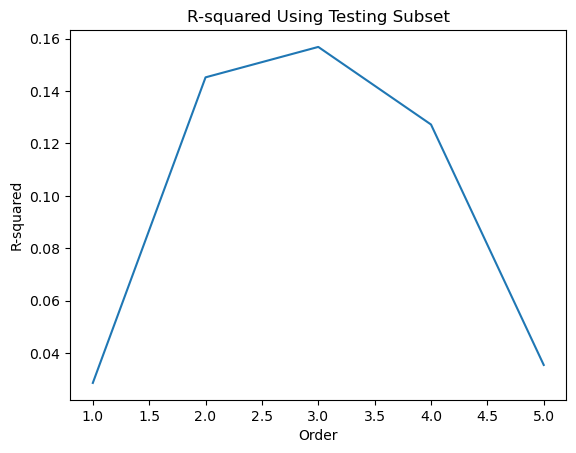

In [35]:
# Plot the mean R-squared of each model by degree. 

plt.plot(order, Rsq_test)
plt.xlabel("Order")
plt.ylabel("R-squared")
plt.title("R-squared Using Testing Subset")

### Polynomial Regression, multiple parameters

In [37]:
# Polynomia Regression, degree = 2, with multiple attributes/parameters. 

pr2 = PolynomialFeatures(degree = 2)
x_train_pr2 = pr2.fit_transform(x_train[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]])
x_test_pr2 = pr2.fit_transform(x_test[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]])

In [41]:
# Ridge Regression model, evaluation by using values of the hyperparameter alpha ranging from 0.001 to 1 with increments of 0.001.

Rsq2_test = []
Rsq2_train = []
Alpha = np.arange(0.001,1,0.001)
pbar = tqdm(Alpha)

for alpha in pbar:
    RidgeModel = Ridge(alpha=alpha) 
    RidgeModel.fit(x_train_pr2, y_train)
    test_score, train_score = RidgeModel.score(x_test_pr2, y_test), RidgeModel.score(x_train_pr2, y_train)
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})
    Rsq2_test.append(test_score)
    Rsq2_train.append(train_score)


100%|██████████| 999/999 [00:03<00:00, 286.78it/s, Test Score=0.507, Train Score=0.642]


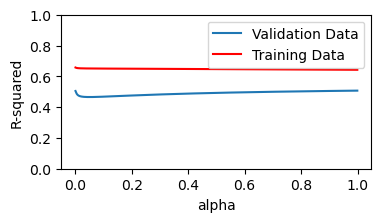

In [42]:
# Plot the mean R-squared values

plt.figure(figsize=(4, 2))  
plt.plot(Alpha, Rsq2_test, label="Validation Data")
plt.plot(Alpha, Rsq2_train, 'r', label="Training Data")
plt.xlabel('alpha')
plt.ylabel('R-squared')
plt.ylim(0, 1)
plt.legend()

### Grid Search

In [44]:
# Using the raw data and the same set of features as used above, an example of GridSearchCV function
# to identify the value of alpha at which the model performs best. 
# Assume the set of alpha values to be used as {0.0001, 0.001, 0.01, 0.1, 1, 10}

parameters1 = [{"alpha": [0.0001, 0.001, 0.01, 1, 10]}]

In [45]:
# Grid Search, folds = 4

RR = Ridge()
Grid1 = GridSearchCV(RR, parameters1, cv = 4)

In [46]:
# Fitting the Grid to the train subset

Grid1.fit(x_train[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]], y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 1, 10]}])

In [48]:
# R-squared score for the test data applying the estimator that uses the derived optimum value of alpha.

BestRR = Grid1.best_estimator_
print(BestRR.score(x_test[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]], y_test))

0.42296349452687465
